<a href="https://colab.research.google.com/github/AndyDengFKu/DPA1/blob/main/Resnet_ResNeXt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import h5py
import os
import csv
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
with h5py.File('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/Padding_WSI_data.h5', 'r') as hf:
    train_images = hf['train_images'][:]
    train_labels = hf['train_labels'][:]
    val_images = hf['val_images'][:]
    val_labels = hf['val_labels'][:]

class WSIDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

train_dataset = WSIDataset(train_images, train_labels)
val_dataset = WSIDataset(val_images, val_labels)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

resnet50 = models.resnet50(pretrained=False)
resnext50 = models.resnext50_32x4d(pretrained=False)

resnet50 = resnet50.to(device)
resnext50 = resnext50.to(device)

# Define loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_resnet50 = torch.optim.SGD(resnet50.parameters(), lr=0.01, momentum=0.9)
optimizer_resnext50 = torch.optim.SGD(resnext50.parameters(), lr=0.01, momentum=0.9)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
num_epochs = 50  # Adjust this value as needed
training_loss_resnet50, validation_loss_resnet50 = [], []
training_loss_resnext50, validation_loss_resnext50 = [], []

# Train models
for epoch in range(num_epochs):
    # Train ResNet-50
    resnet50.train()
    running_loss_resnet50 = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Move data and target to the same device as models
        optimizer_resnet50.zero_grad()
        output = resnet50(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_resnet50.step()
        running_loss_resnet50 += loss.item()

    # Train ResNeXt-50
    resnext50.train()
    running_loss_resnext50 = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Move data and target to the same device as models
        optimizer_resnext50.zero_grad()
        output = resnext50(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer_resnext50.step()
        running_loss_resnext50 += loss.item()

    # Validate ResNet-50
    resnet50.eval()
    running_val_loss_resnet50 = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)  # Move data and target to the same device as models
            output = resnet50(data)
            loss = criterion(output, target)
            running_val_loss_resnet50 += loss.item()

    # Validate ResNeXt-50
    resnext50.eval()
    running_val_loss_resnext50 = 0.0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)  # Move data and target to the same device as models
            output = resnext50(data)
            loss = criterion(output, target)
            running_val_loss_resnext50 += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Training Loss ResNet-50: {running_loss_resnet50/len(train_loader)}, '
          f'Training Loss ResNeXt-50: {running_loss_resnext50/len(train_loader)}, '
          f'Validation Loss ResNet-50: {running_val_loss_resnet50/len(val_loader)}, '
          f'Validation Loss ResNeXt-50: {running_val_loss_resnext50/len(val_loader)}')

    # Record loss data
    training_loss_resnet50.append(running_loss_resnet50/len(train_loader))
    validation_loss_resnet50.append(running_val_loss_resnet50/len(val_loader))
    training_loss_resnext50.append(running_loss_resnext50/len(train_loader))
    validation_loss_resnext50.append(running_val_loss_resnext50/len(val_loader))


Epoch 1/50, Training Loss ResNet-50: 0.5562185607453348, Training Loss ResNeXt-50: 0.5380014272710618, Validation Loss ResNet-50: 0.8417991973286452, Validation Loss ResNeXt-50: 0.45358071952711704
Epoch 2/50, Training Loss ResNet-50: 0.4388613901972193, Training Loss ResNeXt-50: 0.4084649168135469, Validation Loss ResNet-50: 2.4964320474239283, Validation Loss ResNeXt-50: 0.3881647944623648
Epoch 3/50, Training Loss ResNet-50: 0.4145210154270317, Training Loss ResNeXt-50: 0.3809358797040625, Validation Loss ResNet-50: 0.4116704830423344, Validation Loss ResNeXt-50: 0.42747563314299253
Epoch 4/50, Training Loss ResNet-50: 0.38643329289887757, Training Loss ResNeXt-50: 0.36623704884086944, Validation Loss ResNet-50: 0.38838685641801635, Validation Loss ResNeXt-50: 0.4090368332731169
Epoch 5/50, Training Loss ResNet-50: 0.3701827888342406, Training Loss ResNeXt-50: 0.3560061346444637, Validation Loss ResNet-50: 0.3992852856253469, Validation Loss ResNeXt-50: 0.37983629471340846
Epoch 6/5

In [ ]:
# Save trained models
torch.save(resnet50.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/resnet50_trained.pth')
torch.save(resnext50.state_dict(), '/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/resnext50_trained.pth')


In [ ]:

# Save loss data to CSV files
with open('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/training_validation_loss_resnet50.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])
    for epoch, (train_loss, val_loss) in enumerate(zip(training_loss_resnet50, validation_loss_resnet50), 1):
        writer.writerow([epoch, train_loss, val_loss])

with open('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/training_validation_loss_resnext50.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])
    for epoch, (train_loss, val_loss) in enumerate(zip(training_loss_resnext50, validation_loss_resnext50), 1):
        writer.writerow([epoch, train_loss, val_loss])

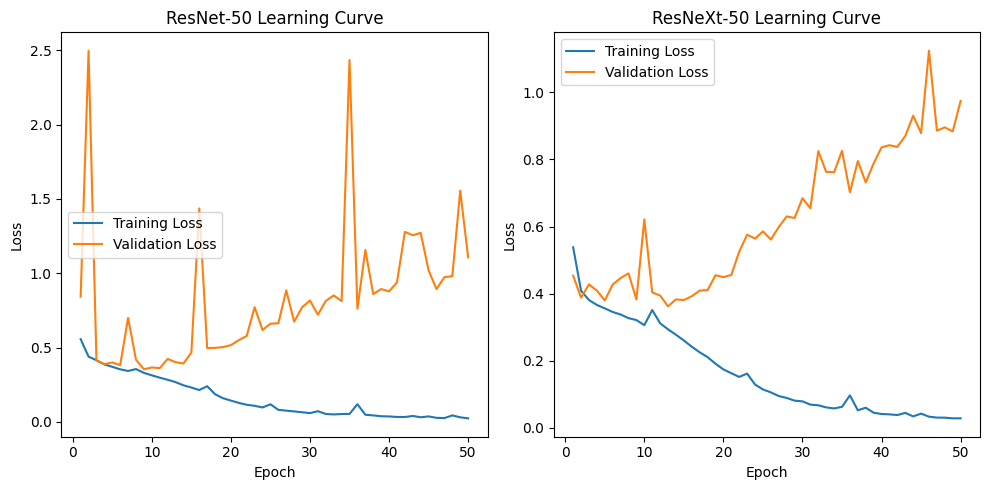

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
resnet50_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/training_validation_loss_resnet50.csv')
resnext50_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/training_validation_loss_resnext50.csv')

# Plot training and validation loss for ResNet-50
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(resnet50_data['Epoch'], resnet50_data['Training Loss'], label='Training Loss')
plt.plot(resnet50_data['Epoch'], resnet50_data['Validation Loss'], label='Validation Loss')
plt.title('ResNet-50 Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation loss for ResNeXt-50
plt.subplot(1,2,2)
plt.plot(resnext50_data['Epoch'], resnext50_data['Training Loss'], label='Training Loss')
plt.plot(resnext50_data['Epoch'], resnext50_data['Validation Loss'], label='Validation Loss')
plt.title('ResNeXt-50 Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


ResNet-50: Precision: 0.82, Recall: 0.78, F1 Score: 0.80, Accuracy: 0.84, ROC AUC: 0.90
ResNeXt-50: Precision: 0.79, Recall: 0.82, F1 Score: 0.80, Accuracy: 0.84, ROC AUC: 0.90


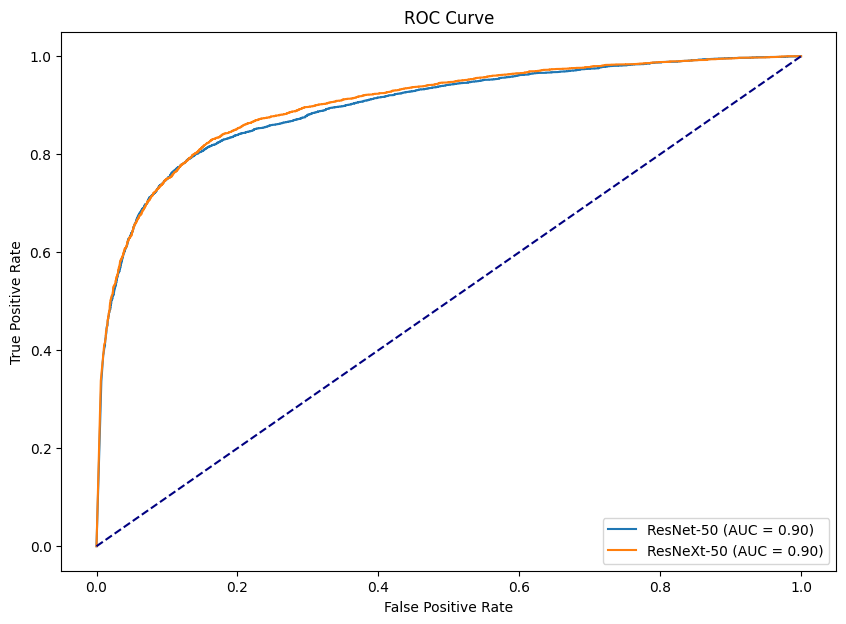

In [ ]:
# 初始化模型
resnet50 = models.resnet50(pretrained=False)
resnext50 = models.resnext50_32x4d(pretrained=False)

# Load saved model parameters
resnet50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/resnet50_trained.pth'))
resnext50.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DeepLearning/A2/resnext50_trained.pth'))


def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    y_score = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            _, pred = torch.max(output, 1)
            score = torch.softmax(output, dim=1)[:, 1]
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            y_score.extend(score.cpu().numpy())

    return y_true, y_pred, y_score

# 评估模型在验证集上的性能
y_true_resnet50, y_pred_resnet50, y_score_resnet50 = evaluate(resnet50, val_loader)
y_true_resnext50, y_pred_resnext50, y_score_resnext50 = evaluate(resnext50, val_loader)

# Compute metrics
def compute_metrics(y_true, y_pred, y_score):
    precision = precision_score(y_true, y_pred, average='binary')  # assuming binary classification
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return precision, recall, f1, accuracy, roc_auc, fpr, tpr

# ResNet-50 metrics
precision_resnet50, recall_resnet50, f1_resnet50, accuracy_resnet50, roc_auc_resnet50, fpr_resnet50, tpr_resnet50 = compute_metrics(y_true_resnet50, y_pred_resnet50, y_score_resnet50)

# ResNeXt-50 metrics
precision_resnext50, recall_resnext50, f1_resnext50, accuracy_resnext50, roc_auc_resnext50, fpr_resnext50, tpr_resnext50 = compute_metrics(y_true_resnext50, y_pred_resnext50, y_score_resnext50)

# Print metrics
print(f'ResNet-50: Precision: {precision_resnet50:.2f}, Recall: {recall_resnet50:.2f}, F1 Score: {f1_resnet50:.2f}, Accuracy: {accuracy_resnet50:.2f}, ROC AUC: {roc_auc_resnet50:.2f}')
print(f'ResNeXt-50: Precision: {precision_resnext50:.2f}, Recall: {recall_resnext50:.2f}, F1 Score: {f1_resnext50:.2f}, Accuracy: {accuracy_resnext50:.2f}, ROC AUC: {roc_auc_resnext50:.2f}')

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr_resnet50, tpr_resnet50, label=f'ResNet-50 (AUC = {roc_auc_resnet50:.2f})')
plt.plot(fpr_resnext50, tpr_resnext50, label=f'ResNeXt-50 (AUC = {roc_auc_resnext50:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
